# On Analyzing Real World Time Series for Forecasting Stock Data - Amazon
- TUTORIAL: [ARIMA Models in Python](https://github.com/youssefHosni/Practical-Time-Series-In-Python/blob/main/Arima%20Models%20in%20Python/ARIMA_Models_In%C2%A0Python.ipynb)
- Having too many problems with the data, so will add file to gitignore.

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '..'))

from collections import namedtuple
from data_loader import build_stock_uts, build_any_univariate_time_series
from ts_models import Model, RandomWalk, PersistenceWalkForward, AR, MA, ARMA, ARIMA_model, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Stock Data Analysis

1. Load Raw TS
2. Plot Raw TS
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw TS
4. Check Stationarity of Raw TS
5. Plot Autocorrelation and Partial Autocorrelation of Raw TS
6. Get Differenced TS
7. Plot Differenced TS
8. Get Descriptive Statistics of Differenced TS
9. Check Stationarity of Raw TS
10. Plot Autocorrelation and Partial Autocorrelation of Raw TS
11. Initialize and Predict Random Walk `RW` Model for Raw TS
12. Plot Actual Forecasts vs Predicted Forecasts for Raw TS
13. Initialize Autoregressive Integrated Moving Average `ARIMA(p, d, q)` for Raw TS
14. Predict Forecasts for Raw TS
15. Plot Actual Forecasts vs Predicted Forecasts for Raw TS
16. Follow-up

### Load Raw TS

In [2]:
file = "../datasets/misc_financial.csv"

In [3]:
ts_of_interest = build_any_univariate_time_series(file)
type(ts_of_interest), ts_of_interest

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Observations))

In [4]:
ts_of_interest_df = ts_of_interest.get_as_df()
ts_of_interest_df

,Observations
Timestamp,
2019-02-08,1588.22
2019-02-07,1614.37
2019-02-06,1640.26
2019-02-05,1658.81
2019-02-04,1633.31
...,...
2014-02-14,357.35
2014-02-13,357.2
2014-02-12,349.25


In [5]:
ts_of_interest_reversed = ts_of_interest.data_augment_reverse()
type(ts_of_interest_reversed), ts_of_interest_reversed

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Observations))

In [6]:
ts_df = ts_of_interest_reversed.get_as_df()
ts_df

,Observations
Timestamp,
2014-02-10,360.87
2014-02-11,361.79
2014-02-12,349.25
2014-02-13,357.2
2014-02-14,357.35
...,...
2019-02-04,1633.31
2019-02-05,1658.81
2019-02-06,1640.26


### Plot Raw TS

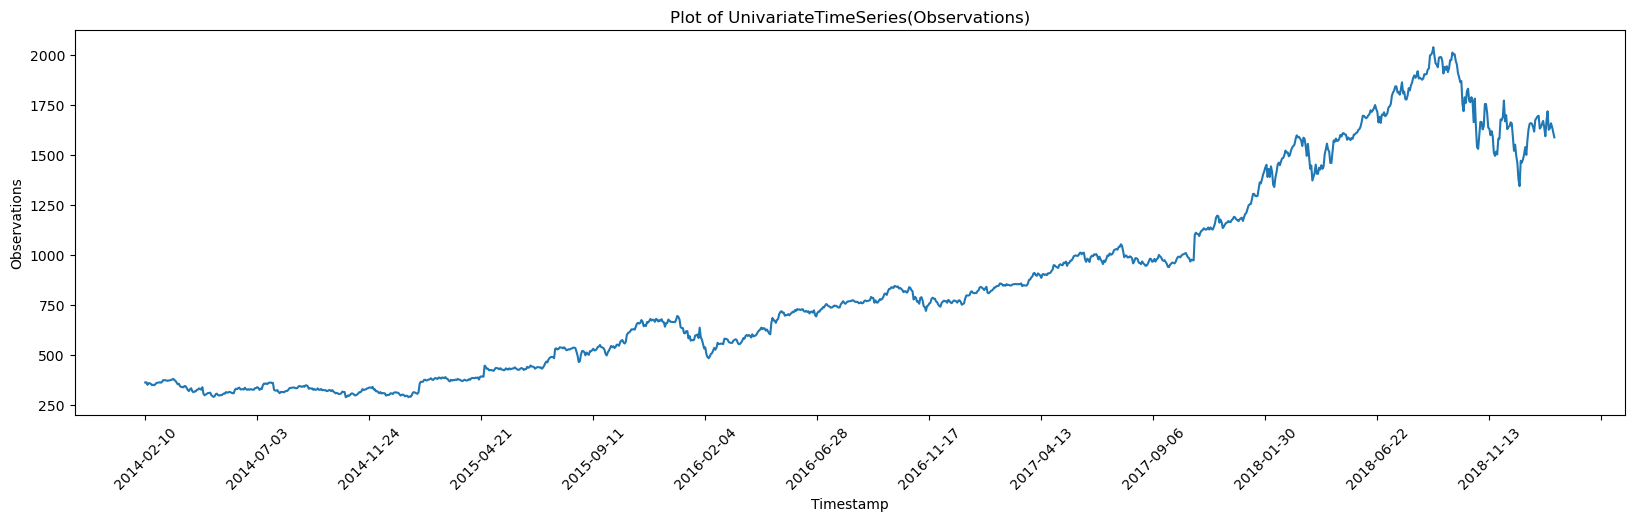

In [7]:
ts_of_interest_reversed.plot(tick_skip=100)

In [8]:
ts_of_interest_reversed

UnivariateTimeSeries(Observations)

### Get Descriptive Statistics of Raw TS

In [9]:
ts_of_interest_reversed.get_statistics()

,Observations
count,1259.0
unique,1250.0
top,1390.0
freq,2.0


In [10]:
ts_of_interest_reversed.max_min_range()

{'Max': Observations    2039.51
 dtype: object,
 'Min': Observations    286.95
 dtype: object,
 'Range': Observations    1752.56
 dtype: object}

### Check Stationarity of Raw TS

- With financial data, we expect it to be non-stationary.
    - Can we verify this non-stationary with plotting the Autocorrelation?

In [12]:
ts_of_interest_reversed.stationarity_test(ts_df)

ADF Statistic: -0.107248
p-value: 0.948712 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


### Plot Autocorrelation and Partial Autocorrelation of Raw TS

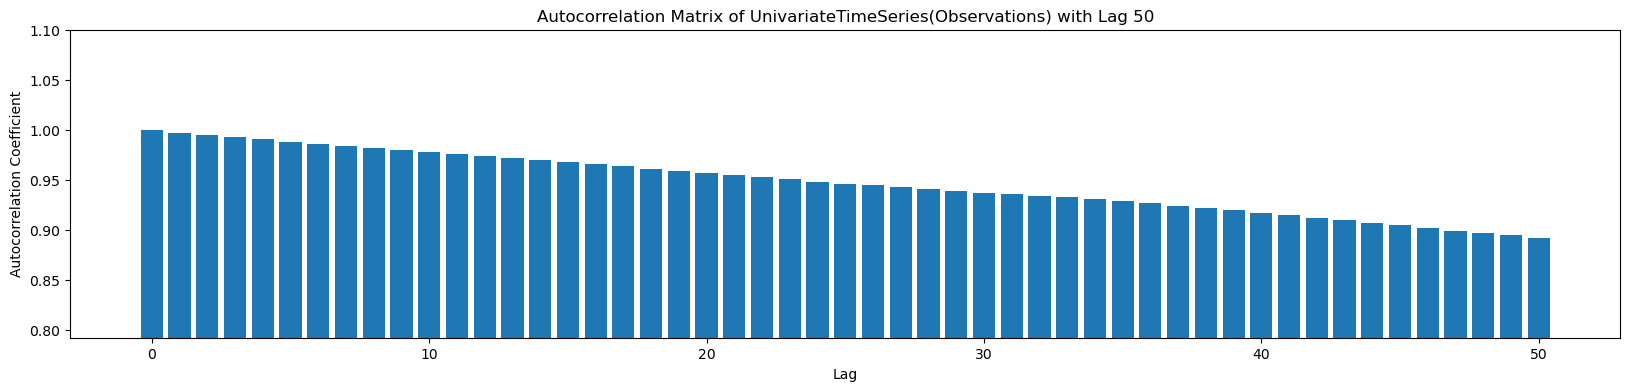

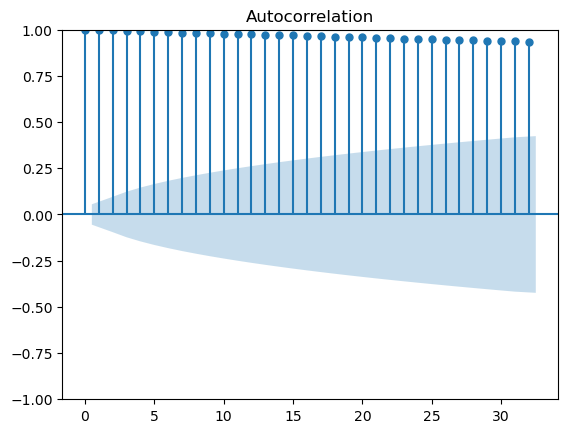

In [13]:
ts_of_interest_reversed.plot_autocorrelation(50)

- Above, the data is highly correlated which means that the k-th lag observation has some impact on the most recent observation.

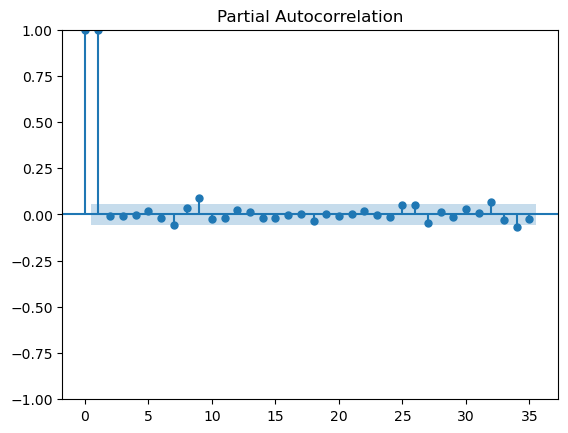

In [14]:
ts_of_interest_reversed.plot_partial_autocorrelation(35)

- Above, the data shows a rapid decay at lag 2. 

### Get Differenced TS
- Remove trend in this case

In [15]:
ts_diff = ts_of_interest_reversed.data_augment_with_differencing(1)
ts_diff

UnivariateTimeSeries(Differenced)

In [16]:
ts_diff_df = ts_diff.get_as_df()
ts_diff_df

,Differenced
Timestamp,
2014-02-11,0.92
2014-02-12,-12.54
2014-02-13,7.95
2014-02-14,0.15
2014-02-18,-3.7
...,...
2019-02-04,7.08
2019-02-05,25.5
2019-02-06,-18.55


### Plot Differenced TS

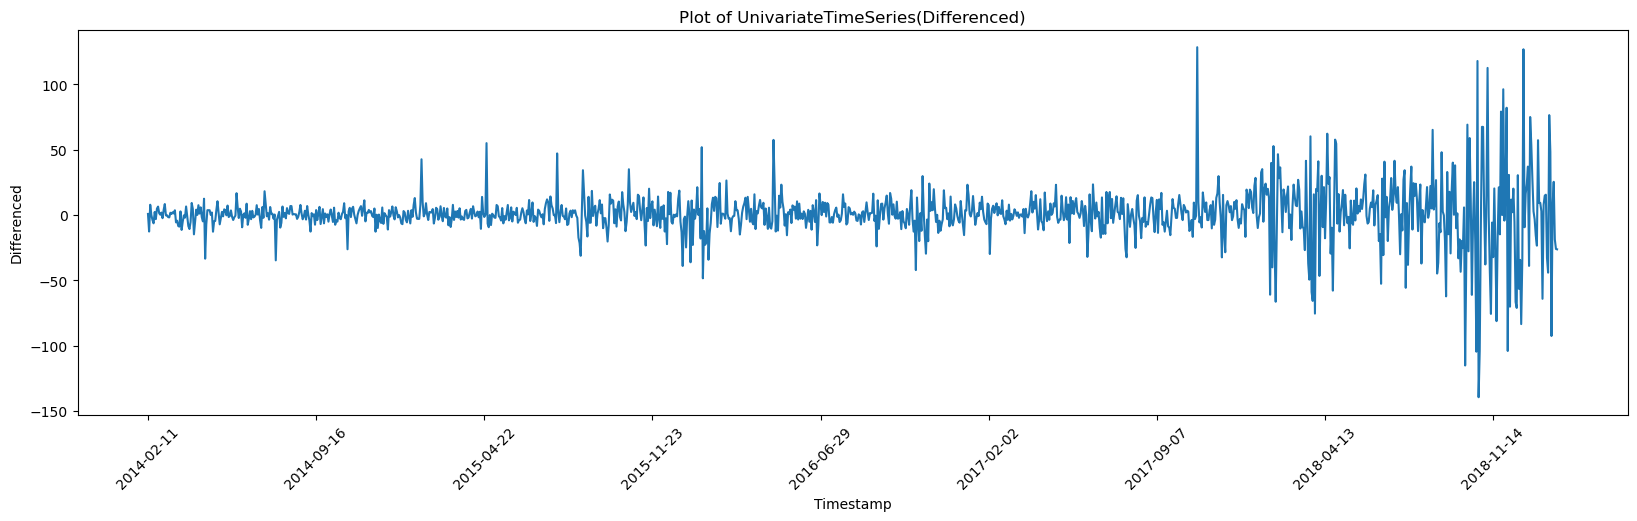

In [17]:
ts_diff.plot(tick_skip=150)

- Differenced TS seems to have constant mean and constant variance although the variance seems to funnel outwardly towards the end

### Get Descriptive Statistics of Differenced TS

In [18]:
ts_diff.get_statistics()

,Differenced
count,1258.00
unique,1154.00
top,-3.38
freq,5.00


In [19]:
ts_diff.max_min_range()

{'Max': Differenced    128.52
 dtype: object,
 'Min': Differenced   -139.36
 dtype: object,
 'Range': Differenced    267.88
 dtype: object}

### Check Stationarity of Differenced TS

In [20]:
ts_diff.stationarity_test(ts_diff_df)

ADF Statistic: -7.201109
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


### Plot Autocorrelation and Partial Autocorrelation of Differenced TS

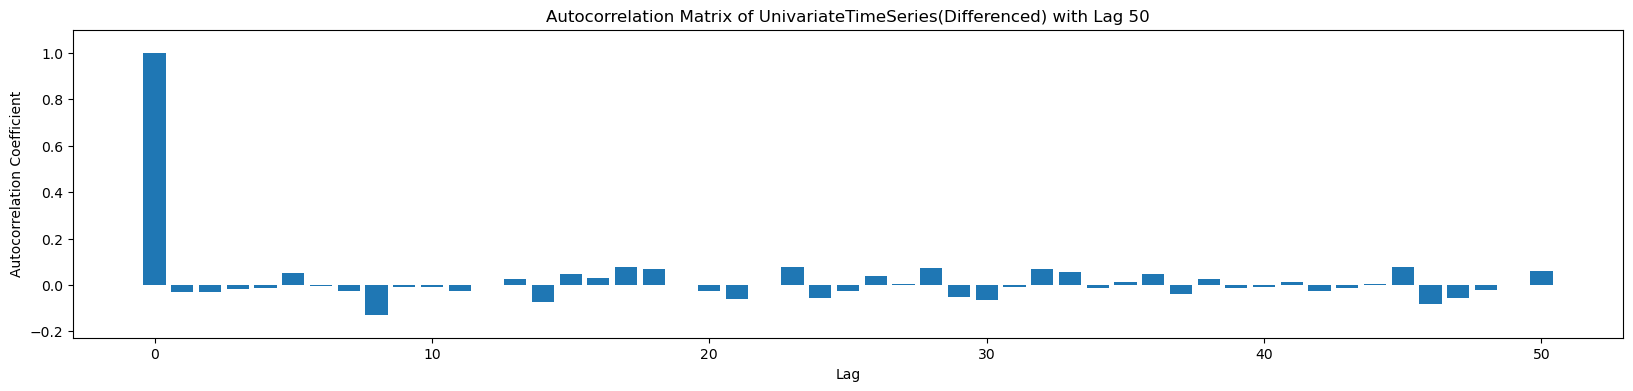

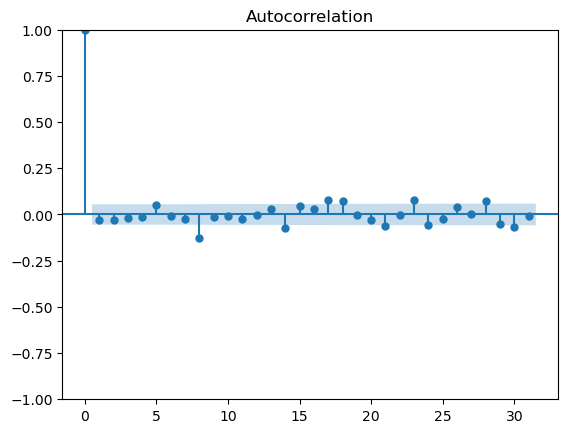

In [21]:
ts_diff.plot_autocorrelation(50)

- ACor exponentially decays at 1. Can test a MA(q), where q = 5, 12, 17, 23, 28 as these are where the values are close or outside of the significance line.

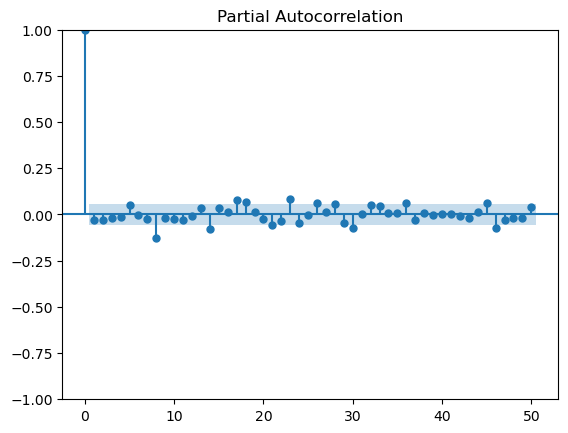

In [22]:
ts_diff.plot_partial_autocorrelation(50)

- PACor exponentially decays at 1. Can test a AR(p), where p = 5, 17, 23 as these are where the values are close or outside of the significance line.

### Initialize and Predict Random Walk RW Model for Raw TS
- Need to fix as it's looking for the train, test split data.

In [63]:
rw_model_class = RandomWalk()

rw_predictions = rw_model_class.predict(ts_of_interest_reversed.get_series(), ts_of_interest_reversed.get_series())

In [64]:
rw_mse_gsts = EvaluationMetric.eval_mse(ts_of_interest_reversed.get_series(), rw_predictions, per_element=False)
rw_mse_gsts

Test MSE: 1587.547


In [65]:
rw_rmse_gsts = EvaluationMetric.eval_rmse(ts_of_interest_reversed.get_series(), rw_predictions, per_element=False)
rw_rmse_gsts

Test RMSE: 39.844


### Plot Actual Forecasts vs Predicted Forecasts for Raw TS

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

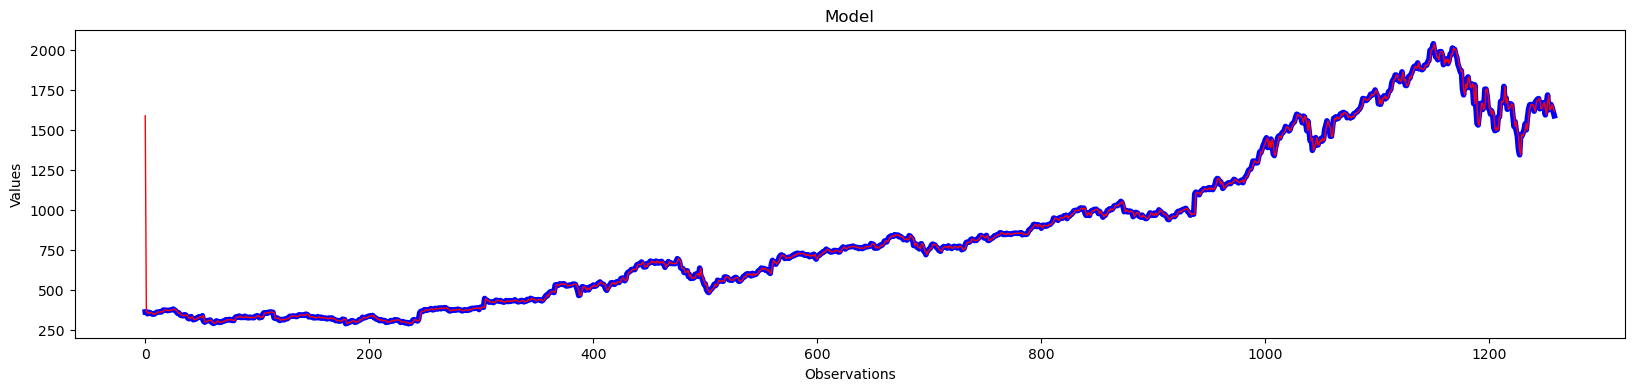

In [66]:
lags_to_test = []
EvaluationMetric.plot_forecast(ts_of_interest_reversed.get_series(), rw_predictions, lags_to_test, with_lags=False)

### Initialize ARIMA(p, d, q) Model for Raw TS

- How to choose d? Compare differenced values 1, 2, etc by looking at the ACor plot. Is there a large change in any difference orders? Should NOT be overdifferenced.

In [23]:
true_labels = ts_of_interest_reversed.get_series()
true_labels

array([360.87, 361.79, 349.25, ..., 1640.26, 1614.37, 1588.22],
      dtype=object)

In [57]:
end = len(ts_df)

subset_of_true_labels = true_labels[:end]
len(subset_of_true_labels), np.shape(subset_of_true_labels)

(1259, (1259,))

In [58]:
flattened_array = subset_of_true_labels.flatten()
flattened_array

# Using ravel()
# raveled_array = original_array.ravel()

array([360.87, 361.79, 349.25, ..., 1640.26, 1614.37, 1588.22],
      dtype=object)

In [67]:
# create an object from the ARIMA_model() class
arima_model_class = ARIMA_model()

# call the function to train our ARIMA model
trained_arima_models = arima_model_class.train_arima_model(ts_of_interest.get, 1, 1, 1)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### Predict Forecasts for Raw TS

In [ ]:
arima_predictions = arima_model_class.predict(trained_arima_models, 1, end)
arima_predictions

In [ ]:
mse_gsts = EvaluationMetric.eval_mse(subset_of_true_labels, arima_predictions)
mse_gsts

In [ ]:
mse_gsts = EvaluationMetric.eval_rmse(subset_of_true_labels, arima_predictions)
mse_gsts

### Plot Actual Forecasts vs Predicted Forecasts for Raw TS

In [ ]:
EvaluationMetric.plot_forecast(subset_of_true_labels, arima_predictions, [1], with_lags=True)

### Follow-up
- What can we determine from this?
    - We are overfitting. I think the reason being is that we are telling our ARIMA model to train and predict on the same data.
    
- What to consider?
    - [ ] Splitting the data into a training set and a testing set.
    - [ ] Log Likelihood
    - [ ] AIC
    - [ ] BIC
    - [ ] HQIC
    - [ ] Ljung-Box (L1) (Q)
    - [ ] Jarque-Bera (JB)
    - [ ] Prob(Q):
    - [ ] Prob(JB):
    - [ ] Heteroskedasticity (H):
    - [ ] Skew
    - [ ] Prob(H) (two-sided)
    - [ ] Kurtosis